In [1]:
################################################################################################################################
#
# LSTM - JANSEN - LNDIFF - DAILY
#
################################################################################################################################

#-------------------------------------------------------------------------------------------------------------------------------
# 
#-------------------------------------------------------------------------------------------------------------------------------

#===============================================================================================================================
# ENVIRONMENT: LIBRARIES, SETTINGS
#===============================================================================================================================
#pip install pandas-datareader

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
import sklearn
import sklearn.preprocessing
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation
from tensorflow import keras

In [2]:
#===============================================================================================================================
# ENVIRONMENT: HARDWARE
#===============================================================================================================================
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [3]:
#===============================================================================================================================
# ENVIRONMENT: CONFIG
#===============================================================================================================================
sns.set_style('whitegrid')
np.random.seed(42)

In [4]:
#===============================================================================================================================
# DATA: INPUT/OUTPUT
#===============================================================================================================================
input_path = Path('Data', 'Input')
results_path = Path('Data\Output', 'LSTM-Jansen-LnDiff-Daily')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [5]:
#===============================================================================================================================
# DATA: SETTINGS
#===============================================================================================================================
seriesId='IBOV'
#ESCALA = 'log'
#EPOCAS = 100
#LOTE = 21
#NEURONS = 12
window_size=21

#===============================================================================================================================
# DATA: READ
#===============================================================================================================================
df = pd.read_csv(seriesId+'.csv')
df.drop(['Open','Low','High', 'Qt'], axis='columns', inplace=True )
#df['Date']= pd.to_datetime(df['Date'], format='%d/%m/%Y')
#df.set_index('Date', inplace=True)
df

,Date,Close
0,03/01/2000,16930.42
1,04/01/2000,15851.00
2,05/01/2000,16245.14
3,06/01/2000,16106.89
4,07/01/2000,16309.15
...,...,...
5938,21/12/2023,132182.01
5939,22/12/2023,132752.93
5940,26/12/2023,133532.92
5941,27/12/2023,134193.72


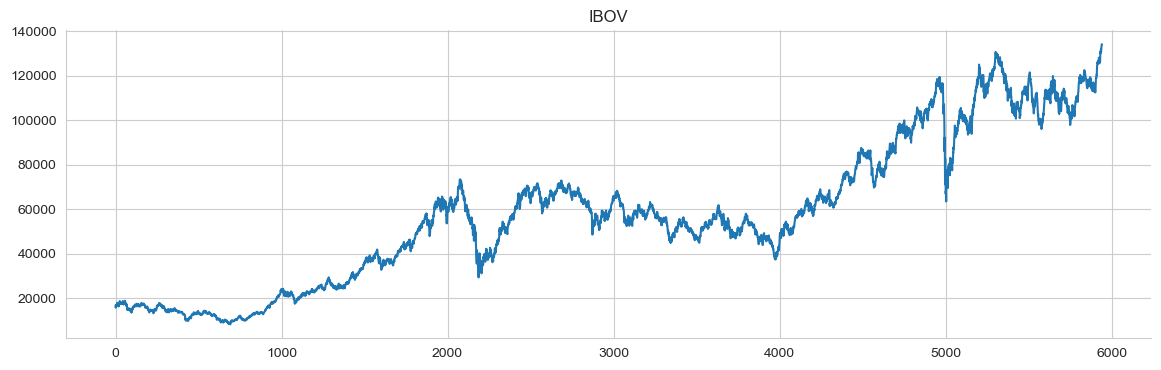

In [6]:
#===============================================================================================================================
# DATA: PLOT
#===============================================================================================================================
ax = df.plot(title=seriesId, legend=False, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [7]:
#===============================================================================================================================
# DATA: SCALE - LOG
#===============================================================================================================================
df_temp = df.copy()
df_temp['Close'] = np.log(df_temp['Close'])
df_temp

,Date,Close
0,03/01/2000,9.736867
1,04/01/2000,9.670988
2,05/01/2000,9.695549
3,06/01/2000,9.687002
4,07/01/2000,9.699482
...,...,...
5938,21/12/2023,11.791935
5939,22/12/2023,11.796245
5940,26/12/2023,11.802103
5941,27/12/2023,11.807040


In [8]:
#===============================================================================================================================
# DATA: SCALE - LOGDIFF
#===============================================================================================================================
df_scaled = df.copy()
df_scaled['Close'] = 0
df_scaled.loc[1:, ['Close']] = df_temp.loc[:, 'Close'].diff()
df_scaled

#df_scaled.describe()

,Date,Close
0,03/01/2000,0.000000
1,04/01/2000,-0.065879
2,05/01/2000,0.024561
3,06/01/2000,-0.008547
4,07/01/2000,0.012479
...,...,...
5938,21/12/2023,0.010479
5939,22/12/2023,0.004310
5940,26/12/2023,0.005858
5941,27/12/2023,0.004936


In [9]:
df_temp.loc[0, 'CloseRecover'] = 0
df_temp.loc[0, 'CloseRecover'] = df_temp.loc[0,'Close']
df_temp['CloseRecover'] = df_temp.loc[0, 'CloseRecover']+df_scaled['Close'].cumsum()
#df_temp[['CloseRecover']] = df_scaled.loc[,'Close'].cumsum()
#df_temp
#df_scaled['Close'].cumsum()
#len(df_temp), len(df_scaled)
df_temp

,Date,Close,CloseRecover
0,03/01/2000,9.736867,9.736867
1,04/01/2000,9.670988,9.670988
2,05/01/2000,9.695549,9.695549
3,06/01/2000,9.687002,9.687002
4,07/01/2000,9.699482,9.699482
...,...,...,...
5938,21/12/2023,11.791935,11.791935
5939,22/12/2023,11.796245,11.796245
5940,26/12/2023,11.802103,11.802103
5941,27/12/2023,11.807040,11.807040


In [10]:
#df['Date']= pd.to_datetime(df['Date'], format='%d/%m/%Y')
#df.set_index('Date', inplace=True)

df_scaled['Date']= pd.to_datetime(df_scaled['Date'], format='%d/%m/%Y')
df_scaled.set_index('Date', inplace=True)
df_scaled


,Close
Date,
2000-01-03,0.000000
2000-01-04,-0.065879
2000-01-05,0.024561
2000-01-06,-0.008547
2000-01-07,0.012479
...,...
2023-12-21,0.010479
2023-12-22,0.004310
2023-12-26,0.005858


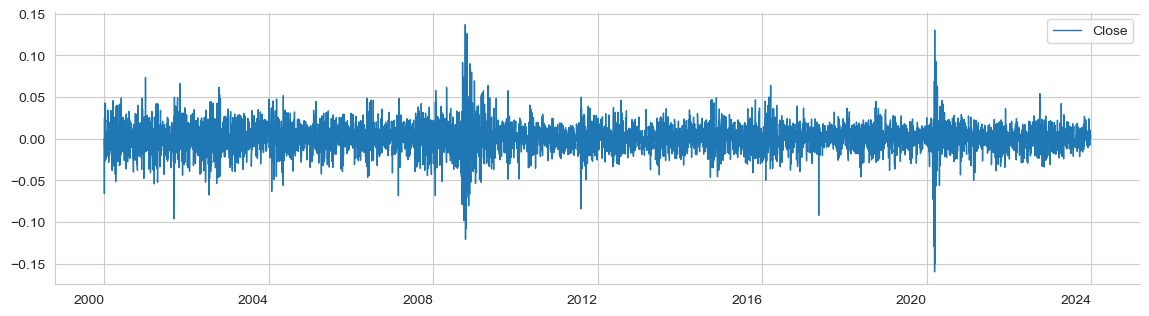

In [11]:
#===============================================================================================================================
# DATA: LOG - PLOT
#===============================================================================================================================
ax = df_scaled.plot(lw=1, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [12]:
#===============================================================================================================================
# DATA: PREP - RECURRENT SEQUENCES - FUNCTION
#===============================================================================================================================
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    #y = data[window_size-1:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    #X = np.hstack(tuple([data[i: n-j+1, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

In [13]:
#===============================================================================================================================
# DATA: PREP - SEQUENCES
#===============================================================================================================================
X, y = create_univariate_rnn_data(df_scaled, window_size=window_size)
X


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
Date,,,,,,,,,,,,,,,,,,,,,
2000-02-02,0.000000,-0.065879,0.024561,-0.008547,0.012479,0.042788,-0.026756,0.002660,0.040176,0.020591,...,-0.008343,-0.024482,-0.016943,-0.008332,-0.003675,0.007837,-0.001410,-0.020510,-0.020900,0.008139
2000-02-03,-0.065879,0.024561,-0.008547,0.012479,0.042788,-0.026756,0.002660,0.040176,0.020591,0.022138,...,-0.024482,-0.016943,-0.008332,-0.003675,0.007837,-0.001410,-0.020510,-0.020900,0.008139,0.020741
2000-02-04,0.024561,-0.008547,0.012479,0.042788,-0.026756,0.002660,0.040176,0.020591,0.022138,-0.008343,...,-0.016943,-0.008332,-0.003675,0.007837,-0.001410,-0.020510,-0.020900,0.008139,0.020741,0.034302
2000-02-07,-0.008547,0.012479,0.042788,-0.026756,0.002660,0.040176,0.020591,0.022138,-0.008343,-0.024482,...,-0.008332,-0.003675,0.007837,-0.001410,-0.020510,-0.020900,0.008139,0.020741,0.034302,0.026865
2000-02-08,0.012479,0.042788,-0.026756,0.002660,0.040176,0.020591,0.022138,-0.008343,-0.024482,-0.016943,...,-0.003675,0.007837,-0.001410,-0.020510,-0.020900,0.008139,0.020741,0.034302,0.026865,0.010712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,0.003253,0.004279,-0.008398,0.001705,0.006397,-0.002950,0.009195,0.006683,-0.010841,0.000792,...,0.003075,0.008566,-0.001395,-0.004053,0.023936,0.010580,-0.004942,0.006788,0.005835,-0.007970
2023-12-22,0.004279,-0.008398,0.001705,0.006397,-0.002950,0.009195,0.006683,-0.010841,0.000792,-0.010142,...,0.008566,-0.001395,-0.004053,0.023936,0.010580,-0.004942,0.006788,0.005835,-0.007970,0.010479
2023-12-26,-0.008398,0.001705,0.006397,-0.002950,0.009195,0.006683,-0.010841,0.000792,-0.010142,0.003075,...,-0.001395,-0.004053,0.023936,0.010580,-0.004942,0.006788,0.005835,-0.007970,0.010479,0.004310


In [14]:
#===============================================================================================================================
# DATA: PREP - SPLIT
#===============================================================================================================================
X_train = X[:'2022'].values.reshape(-1, window_size, 1)
y_train = y[:'2022']

# keep the last year for testing
X_test = X['2023':].values.reshape(-1, window_size, 1)
y_test = y['2023':]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5674, 21, 1), (5674, 1), (248, 21, 1), (248, 1))

In [15]:
#===============================================================================================================================
# DATA: PREP - OBS, WINDOWS, FEATURES
#===============================================================================================================================
n_obs, window_size, n_features = X_train.shape
n_obs, window_size, n_features

(5674, 21, 1)

In [16]:
#===============================================================================================================================
# MODEL: CONFIG - LSTM
#===============================================================================================================================
rnn = Sequential([
    LSTM(units=10, input_shape=(window_size, n_features), name='LSTM'),
    Dense(1, name='Output')
])

rnn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 10)                480       
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
#===============================================================================================================================
# MODEL: CONFIG - OPTIMIZER
#===============================================================================================================================
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, weight_decay=0.0)

rnn.compile(loss='mean_squared_error', optimizer=optimizer)

rnn_path = (results_path / 'LnDiff-Daily-rnn.h5').as_posix()
checkpointer = ModelCheckpoint(filepath=rnn_path, verbose=1, monitor='val_loss', save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [18]:
#===============================================================================================================================
# MODEL: TRAIN
#===============================================================================================================================
lstm_training = rnn.fit(X_train, y_train, epochs=150, batch_size=20, shuffle=True, 
                        validation_data=(X_test, y_test), 
                        callbacks=[early_stopping, checkpointer],verbose=1)

Epoch 1/150

284/284 [==============================] - ETA: 0s - loss: 3.3149e-04
Epoch 1: val_loss improved from inf to 0.00013, saving model to Data/Output/LSTM-Jansen-LnDiff-Daily\LnDiff-Daily-rnn.h5
284/284 [==============================] - 14s 22ms/step - loss: 3.3149e-04 - val_loss: 1.2874e-04
Epoch 2/150
283/284 [============================>.] - ETA: 0s - loss: 3.2801e-04
Epoch 2: val_loss improved from 0.00013 to 0.00012, saving model to Data/Output/LSTM-Jansen-LnDiff-Daily\LnDiff-Daily-rnn.h5
284/284 [==============================] - 4s 15ms/step - loss: 3.2772e-04 - val_loss: 1.1832e-04
Epoch 3/150
280/284 [============================>.] - ETA: 0s - loss: 3.2656e-04
Epoch 3: val_loss did not improve from 0.00012
284/284 [==============================] - 4s 15ms/step - loss: 3.2706e-04 - val_loss: 1.5594e-04
Epoch 4/150
284/284 [==============================] - ETA: 0s - loss: 3.2460e-04
Epoch 4: val_loss improved from 0.00012 to 0.00012, saving model to Data/Output/LST

Epoch 34/150
282/284 [============================>.] - ETA: 0s - loss: 3.2033e-04
Epoch 34: val_loss did not improve from 0.00012
284/284 [==============================] - 5s 16ms/step - loss: 3.1971e-04 - val_loss: 1.1680e-04
Epoch 35/150
282/284 [============================>.] - ETA: 0s - loss: 3.1963e-04
Epoch 35: val_loss did not improve from 0.00012
284/284 [==============================] - 5s 17ms/step - loss: 3.1901e-04 - val_loss: 1.2226e-04
Epoch 36/150
282/284 [============================>.] - ETA: 0s - loss: 3.1976e-04
Epoch 36: val_loss did not improve from 0.00012
284/284 [==============================] - 4s 15ms/step - loss: 3.1971e-04 - val_loss: 1.2342e-04
Epoch 37/150
281/284 [============================>.] - ETA: 0s - loss: 3.1976e-04
Epoch 37: val_loss did not improve from 0.00012
284/284 [==============================] - 5s 16ms/step - loss: 3.1869e-04 - val_loss: 1.1714e-04
Epoch 38/150
283/284 [============================>.] - ETA: 0s - loss: 3.1947e-04
E

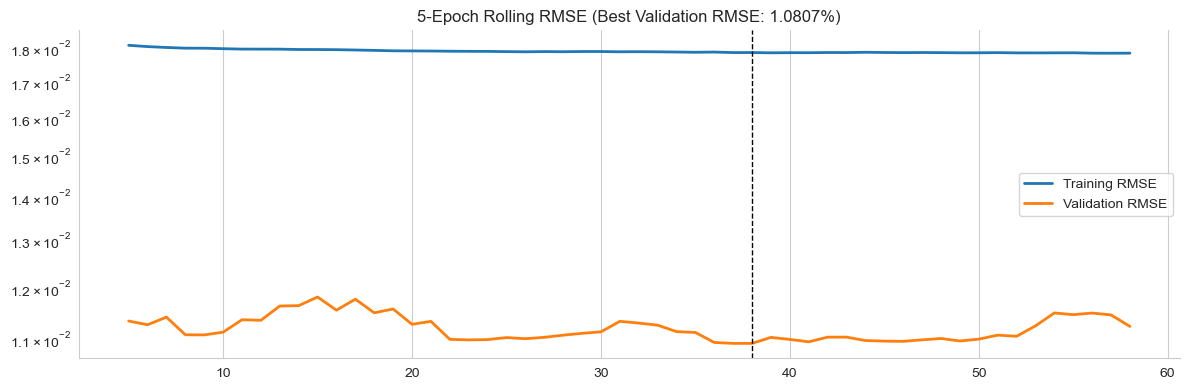

In [19]:
#===============================================================================================================================
# RESULTS - PERFORMANCE vs EPOCHS - TRAIN, VALIDATION
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_error', dpi=300);

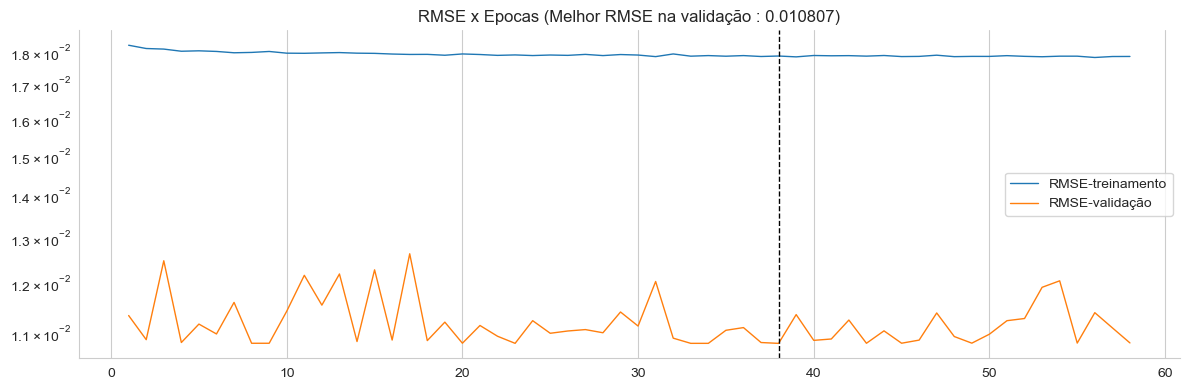

In [20]:
#===============================================================================================================================
# RESULTS - PERFORMANCE vs EPOCHS - TRAIN, VALIDATION
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'RMSE x Epocas (Melhor RMSE na validação : {best_rmse:.6})'
loss_history.columns=['RMSE-treinamento', 'RMSE-validação']
loss_history.rolling(1).mean().plot(logy=True, lw=1, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_error', dpi=300);

In [21]:
#===============================================================================================================================
# RESULTS - PERFORMANCE - TRAIN, TEST
#===============================================================================================================================
train_rmse_scaled = np.sqrt(rnn.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')
#-------------------------------------------------------------------------------------------------------------------------------
# Train RMSE: 0.0178 | Test RMSE: 0.0108
#-------------------------------------------------------------------------------------------------------------------------------

Train RMSE: 0.0178 | Test RMSE: 0.0108


In [22]:
#===============================================================================================================================
# RESULTS - FORECAST - TRAIN, TEST
#===============================================================================================================================
train_predict_scaled = rnn.predict(X_train)
test_predict_scaled = rnn.predict(X_test)

8/8 [==============================] - 0s 4ms/step


In [23]:
#===============================================================================================================================
# RESULTS - SPEARMAN IC - TRAIN, TEST
#===============================================================================================================================
train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.6f} | Test IC: {test_ic:.4f}')
#-------------------------------------------------------------------------------------------------------------------------------
# Train IC: 0.022243 | Test IC: -0.0057
#-------------------------------------------------------------------------------------------------------------------------------

Train IC: 0.016486 | Test IC: -0.0146


In [24]:
train_predict_scaled

array([[ 1.2070704e-03],
       [ 6.6684093e-04],
       [-1.2688106e-06],
       ...,
       [ 5.5133697e-04],
       [ 6.3982228e-04],
       [ 3.4534105e-04]], dtype=float32)

In [25]:
#===============================================================================================================================
# RESULTS - FORECAST - SCALED - TEST 
#===============================================================================================================================
np.savetxt('Data/Output/LSTM-Jansen-LnDiff-Daily-Scaled-Train.txt', train_predict_scaled, delimiter=';')
np.savetxt('Data/Output/LSTM-Jansen-LnDiff-Daily-Scaled-Test.txt ', test_predict_scaled , delimiter=';')
test_predict_scaled[:,0]

#-------------------------------------------------------------------------------------------------------------------------------
# Conferir no EXCEL
#-------------------------------------------------------------------------------------------------------------------------------

array([ 5.6775101e-04,  1.3040282e-03,  1.5913176e-03,  1.0962315e-03,
        5.5922027e-04,  3.8927660e-04,  4.8921834e-04,  2.5231548e-04,
        7.9720980e-05,  4.0582928e-04,  6.8293908e-04,  1.0316246e-03,
        5.0354947e-04,  4.3614709e-04,  4.0802080e-04,  6.8648765e-04,
        7.6513714e-04,  5.1787565e-04,  3.5946438e-04,  5.0085335e-04,
        9.3913625e-04,  8.8785507e-04,  6.2869338e-04,  9.4072655e-04,
        1.2779463e-03,  1.4589562e-03,  1.2278713e-03,  1.3033517e-03,
        7.5425027e-04,  1.1931239e-03,  1.0745043e-03,  8.5868489e-04,
        1.0593573e-03,  6.4718688e-04,  6.4268743e-04,  8.5108465e-04,
        1.2469020e-03,  1.0180207e-03,  1.3342658e-03,  1.1992226e-03,
        1.2600729e-03,  1.2539839e-03,  1.3642211e-03,  1.1037486e-03,
        8.6725660e-04,  9.7177539e-04,  4.6326651e-04,  8.8456867e-04,
        1.1656793e-03,  1.1620289e-03,  1.0985838e-03,  1.0768760e-03,
        8.4966910e-04,  1.1626646e-03,  1.2939046e-03,  1.1412888e-03,
      

In [26]:
#===============================================================================================================================
# RESULTS - RECOVER - LN - TRAIN
#===============================================================================================================================
#train_predict = pd.Series(np.exp(train_predict_scaled[:,0]), index=y_train.index)

#train_predict[0] = df_temp.loc[5674,'Close'] 
#train_predict = np.exp(df_temp.loc[5674,'Close']  + train_predict_scaled.cumsum())
#train_predict

In [27]:
#===============================================================================================================================
# RESULTS - RECOVER - LN - TEST
#===============================================================================================================================
#test_predict  = pd.Series(np.exp(test_predict_scaled[:,0]), index=y_test.index)
#test_predict = np.exp(df_temp.loc[5694,'Close'] + test_predict_scaled.cumsum())

#test_predict

In [28]:
#np.savetxt('Data/Output/LSTM-Jansen-LnDiff-Daily-Train.txt', train_predict, delimiter=';')
#np.savetxt('Data/Output/LSTM-Jansen-LnDiff-Daily-Test.txt' , test_predict , delimiter=';')

In [29]:
#===============================================================================================================================
# RESULTS - PRICE - RECOVER - TARGET - TRAIN, TEST
#===============================================================================================================================
#y_train_rescaled = np.exp(y_train['Close'])
#y_test_rescaled  = np.exp(y_test['Close'])

#y_test_rescaled

In [30]:
#===============================================================================================================================
# RESULTS - PRICE - PERFORMANCE - TRAIN, TEST
#===============================================================================================================================
#train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
#test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
#print(f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}')

#-------------------------------------------------------------------------------------------------------------------------------
# 
#-------------------------------------------------------------------------------------------------------------------------------

In [31]:
#===============================================================================================================================
# RESULTS - PRICE - STORE - TRAIN, TEST
#===============================================================================================================================
#df['Train Predictions'] = 0
#df.loc[21:5694,'Train Predictions'] = train_predict
#df['Test Predictions'] = 0
#df.loc[5695:,'Test Predictions'] = test_predict

#temp = pd.concat([train_predict.to_frame('predictions').assign(data='Train'), test_predict.to_frame('predictions').assign(data='Test')])
#df['predictions'] = temp['predictions']
#df['data']        = temp[ 'data']

#df[5694:]

In [32]:
#===============================================================================================================================
# RESULTS - PRICE - EXPORT
#===============================================================================================================================
df.to_excel('Data/Output/LSTM-Jansen-LnDiff-Daily.xlsx')

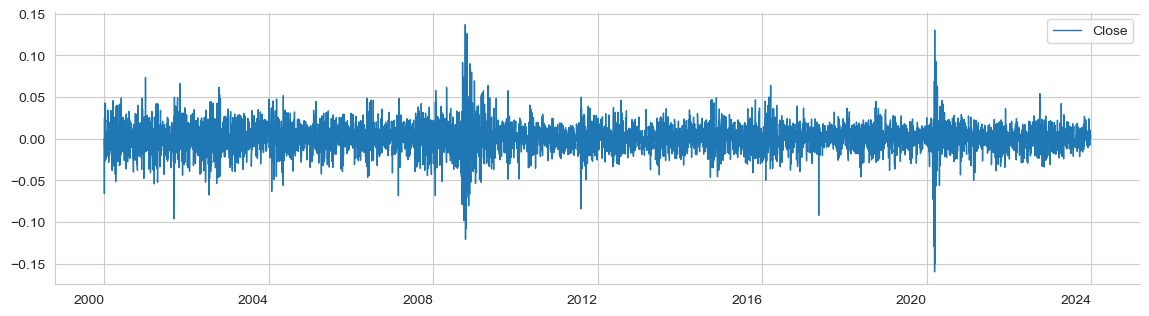

In [33]:
#===============================================================================================================================
# DATA: LOG - PLOT
#===============================================================================================================================
ax = df_scaled.plot(lw=1, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

KeyError: 'predictions'

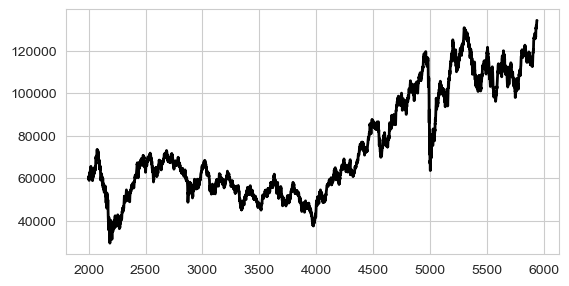

In [34]:
#===============================================================================================================================
# RESULTS - PRICE - PLOT
#===============================================================================================================================
fig=plt.figure(figsize=(14,7))

ax1 = plt.subplot(221)
df.loc['2000':, 'Close'].plot(lw=2, ax=ax1, c='k')
df.loc['2000':, 'predictions'].plot(lw=1.5, ax=ax1, c='k')
df.loc['2000':, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')

with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x='Close', y='predictions', data=df, hue='data', ax=ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')
    
    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE ={test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_regression', dpi=300);
